In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling', 
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling', 
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


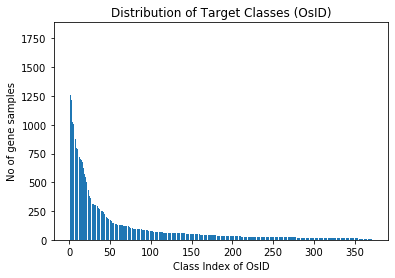

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=120, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

Number of input features: 1
Fold: 1


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 15s 5ms/step - loss: 5.0890 - accuracy: 0.0417 - val_loss: 5.0508 - val_accuracy: 0.0436
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9840 - accuracy: 0.0440 - val_loss: 5.0449 - val_accuracy: 0.0436
Epoch 3/120
1846/1846 [==============================] - 6s 4ms/step - loss: 4.9758 - accuracy: 0.0440 - val_loss: 5.0364 - val_accuracy: 0.0436
Epoch 4/120
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9696 - accuracy: 0.0440 - val_loss: 5.0424 - val_accuracy: 0.0436
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9673 - accuracy: 0.0437 - val_loss: 5.0434 - val_accuracy: 0.0436
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9615 - accuracy: 0.0440 - val_loss: 5.0265 - val_accuracy: 0.0436
Epoch 7/120
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9569 - accuracy: 0.0440 - val_loss: 5.0230 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 15s 5ms/step - loss: 5.0977 - accuracy: 0.0411 - val_loss: 5.0361 - val_accuracy: 0.0436
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9795 - accuracy: 0.0431 - val_loss: 5.0300 - val_accuracy: 0.0436
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9658 - accuracy: 0.0442 - val_loss: 5.0177 - val_accuracy: 0.0436
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9136 - accuracy: 0.0494 - val_loss: 4.9527 - val_accuracy: 0.0528
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8711 - accuracy: 0.0522 - val_loss: 4.9372 - val_accuracy: 0.0495
Epoch 6/120
1846/1846 [==============================] - 8s 4ms/step - loss: 4.8544 - accuracy: 0.0520 - val_loss: 4.9300 - val_accuracy: 0.0510
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8420 - accuracy: 0.0519 - val_loss: 4.9373 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 16s 5ms/step - loss: 5.1022 - accuracy: 0.0416 - val_loss: 5.0457 - val_accuracy: 0.0436
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9675 - accuracy: 0.0477 - val_loss: 5.0071 - val_accuracy: 0.0436
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8254 - accuracy: 0.0754 - val_loss: 4.8405 - val_accuracy: 0.0706
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.7038 - accuracy: 0.0783 - val_loss: 4.7546 - val_accuracy: 0.0781
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.6343 - accuracy: 0.0830 - val_loss: 4.7194 - val_accuracy: 0.0763
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5990 - accuracy: 0.0821 - val_loss: 4.7154 - val_accuracy: 0.0779
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5790 - accuracy: 0.0837 - val_loss: 4.6853 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 14s 4ms/step - loss: 5.0146 - accuracy: 0.0462 - val_loss: 4.7152 - val_accuracy: 0.0774
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.3517 - accuracy: 0.1091 - val_loss: 4.2350 - val_accuracy: 0.1254
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9949 - accuracy: 0.1365 - val_loss: 3.9946 - val_accuracy: 0.1516
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7528 - accuracy: 0.1655 - val_loss: 3.7785 - val_accuracy: 0.1824
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4888 - accuracy: 0.2091 - val_loss: 3.5233 - val_accuracy: 0.2326
Epoch 6/120
1846/1846 [==============================] - 8s 4ms/step - loss: 3.2005 - accuracy: 0.2601 - val_loss: 3.2754 - val_accuracy: 0.2858
Epoch 7/120
1846/1846 [==============================] - 8s 4ms/step - loss: 2.9512 - accuracy: 0.2983 - val_loss: 3.1027 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 5.0641 - accuracy: 0.0414 - val_loss: 4.9667 - val_accuracy: 0.0315
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.6402 - accuracy: 0.0752 - val_loss: 4.4222 - val_accuracy: 0.1074
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0814 - accuracy: 0.1336 - val_loss: 4.0339 - val_accuracy: 0.1351
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7453 - accuracy: 0.1784 - val_loss: 3.7740 - val_accuracy: 0.1833
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4489 - accuracy: 0.2246 - val_loss: 3.4860 - val_accuracy: 0.2114
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0925 - accuracy: 0.2881 - val_loss: 3.1825 - val_accuracy: 0.3052
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7702 - accuracy: 0.3400 - val_loss: 2.9454 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 5.0400 - accuracy: 0.0392 - val_loss: 4.8582 - val_accuracy: 0.0730
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 4.3950 - accuracy: 0.1211 - val_loss: 4.1982 - val_accuracy: 0.1428
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8454 - accuracy: 0.1956 - val_loss: 3.7705 - val_accuracy: 0.2240
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4005 - accuracy: 0.2529 - val_loss: 3.4542 - val_accuracy: 0.2506
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9450 - accuracy: 0.3368 - val_loss: 2.9998 - val_accuracy: 0.3531
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5145 - accuracy: 0.4228 - val_loss: 2.5872 - val_accuracy: 0.4662
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1311 - accuracy: 0.4898 - val_loss: 2.2588 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 5.0255 - accuracy: 0.0376 - val_loss: 4.8863 - val_accuracy: 0.0319
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.6084 - accuracy: 0.0732 - val_loss: 4.4644 - val_accuracy: 0.1028
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1254 - accuracy: 0.1413 - val_loss: 4.0439 - val_accuracy: 0.1749
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7686 - accuracy: 0.1810 - val_loss: 3.7801 - val_accuracy: 0.2011
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5190 - accuracy: 0.1973 - val_loss: 3.6053 - val_accuracy: 0.2257
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3074 - accuracy: 0.2308 - val_loss: 3.4006 - val_accuracy: 0.2684
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0302 - accuracy: 0.3153 - val_loss: 3.1304 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.8190 - accuracy: 0.0449 - val_loss: 4.5773 - val_accuracy: 0.0484
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.3723 - accuracy: 0.0786 - val_loss: 4.3283 - val_accuracy: 0.0843
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1313 - accuracy: 0.0886 - val_loss: 4.1142 - val_accuracy: 0.1122
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9221 - accuracy: 0.1137 - val_loss: 3.9166 - val_accuracy: 0.1199
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6823 - accuracy: 0.1387 - val_loss: 3.6260 - val_accuracy: 0.1767
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3665 - accuracy: 0.1843 - val_loss: 3.3210 - val_accuracy: 0.2128
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0236 - accuracy: 0.2557 - val_loss: 2.9932 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7237 - accuracy: 0.0529 - val_loss: 4.4705 - val_accuracy: 0.0530
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 4.2197 - accuracy: 0.0980 - val_loss: 4.1327 - val_accuracy: 0.1305
Epoch 3/120
1846/1846 [==============================] - 3s 2ms/step - loss: 3.9004 - accuracy: 0.1446 - val_loss: 3.8295 - val_accuracy: 0.1575
Epoch 4/120
1846/1846 [==============================] - 3s 2ms/step - loss: 3.5289 - accuracy: 0.1845 - val_loss: 3.4982 - val_accuracy: 0.2042
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1927 - accuracy: 0.2362 - val_loss: 3.2214 - val_accuracy: 0.2220
Epoch 6/120
1846/1846 [==============================] - 3s 2ms/step - loss: 2.8857 - accuracy: 0.2824 - val_loss: 2.9526 - val_accuracy: 0.3441
Epoch 7/120
1846/1846 [==============================] - 3s 2ms/step - loss: 2.5828 - accuracy: 0.3563 - val_loss: 2.6418 - val_accuracy: 0.34

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.8230 - accuracy: 0.0463 - val_loss: 4.5861 - val_accuracy: 0.0814
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 4.3153 - accuracy: 0.0956 - val_loss: 4.2150 - val_accuracy: 0.1006
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9401 - accuracy: 0.1160 - val_loss: 3.8591 - val_accuracy: 0.1358
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5792 - accuracy: 0.1700 - val_loss: 3.5412 - val_accuracy: 0.1932
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1823 - accuracy: 0.2445 - val_loss: 3.1578 - val_accuracy: 0.2794
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7883 - accuracy: 0.3364 - val_loss: 2.8206 - val_accuracy: 0.3529
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4744 - accuracy: 0.3952 - val_loss: 2.5789 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.8965 - accuracy: 0.0426 - val_loss: 4.7487 - val_accuracy: 0.0497
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.6756 - accuracy: 0.0515 - val_loss: 4.6928 - val_accuracy: 0.0502
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 4.5934 - accuracy: 0.0593 - val_loss: 4.4968 - val_accuracy: 0.0871
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1928 - accuracy: 0.1087 - val_loss: 4.0389 - val_accuracy: 0.1338
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7945 - accuracy: 0.1573 - val_loss: 3.7375 - val_accuracy: 0.1547
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5038 - accuracy: 0.1894 - val_loss: 3.5006 - val_accuracy: 0.2141
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.2579 - accuracy: 0.2247 - val_loss: 3.2636 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 10s 4ms/step - loss: 4.7932 - accuracy: 0.0532 - val_loss: 4.5042 - val_accuracy: 0.0777
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 4.1950 - accuracy: 0.1078 - val_loss: 4.0661 - val_accuracy: 0.1248
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8503 - accuracy: 0.1313 - val_loss: 3.8330 - val_accuracy: 0.1701
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6208 - accuracy: 0.1587 - val_loss: 3.6550 - val_accuracy: 0.1441
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4380 - accuracy: 0.1695 - val_loss: 3.4885 - val_accuracy: 0.1718
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2720 - accuracy: 0.1955 - val_loss: 3.3362 - val_accuracy: 0.2022
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0945 - accuracy: 0.2240 - val_loss: 3.1746 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.7907 - accuracy: 0.0579 - val_loss: 4.4953 - val_accuracy: 0.0970
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 4.1749 - accuracy: 0.1091 - val_loss: 4.0369 - val_accuracy: 0.1091
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7998 - accuracy: 0.1414 - val_loss: 3.7624 - val_accuracy: 0.1564
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5569 - accuracy: 0.1656 - val_loss: 3.5886 - val_accuracy: 0.1626
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3732 - accuracy: 0.1894 - val_loss: 3.4600 - val_accuracy: 0.1723
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2195 - accuracy: 0.2036 - val_loss: 3.2930 - val_accuracy: 0.1989
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0595 - accuracy: 0.2382 - val_loss: 3.1752 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.8312 - accuracy: 0.0495 - val_loss: 4.5769 - val_accuracy: 0.0722
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1904 - accuracy: 0.1089 - val_loss: 4.0450 - val_accuracy: 0.1270
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7513 - accuracy: 0.1527 - val_loss: 3.6687 - val_accuracy: 0.1701
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4179 - accuracy: 0.1998 - val_loss: 3.4025 - val_accuracy: 0.2277
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1572 - accuracy: 0.2413 - val_loss: 3.2006 - val_accuracy: 0.2537
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9381 - accuracy: 0.2851 - val_loss: 3.0193 - val_accuracy: 0.2926
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7287 - accuracy: 0.3217 - val_loss: 2.8444 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.7898 - accuracy: 0.0576 - val_loss: 4.4856 - val_accuracy: 0.0946
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0834 - accuracy: 0.1211 - val_loss: 3.9406 - val_accuracy: 0.1430
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6637 - accuracy: 0.1547 - val_loss: 3.6300 - val_accuracy: 0.1586
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3584 - accuracy: 0.1969 - val_loss: 3.3452 - val_accuracy: 0.2427
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9936 - accuracy: 0.2754 - val_loss: 2.9654 - val_accuracy: 0.3377
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5771 - accuracy: 0.3842 - val_loss: 2.5832 - val_accuracy: 0.4286
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2183 - accuracy: 0.4590 - val_loss: 2.3115 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.8105 - accuracy: 0.0553 - val_loss: 4.4128 - val_accuracy: 0.1008
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0191 - accuracy: 0.1268 - val_loss: 3.8701 - val_accuracy: 0.1287
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6134 - accuracy: 0.1645 - val_loss: 3.5897 - val_accuracy: 0.1683
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3068 - accuracy: 0.2100 - val_loss: 3.2991 - val_accuracy: 0.2407
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9457 - accuracy: 0.2942 - val_loss: 2.9369 - val_accuracy: 0.3281
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5833 - accuracy: 0.3732 - val_loss: 2.6488 - val_accuracy: 0.3780
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2882 - accuracy: 0.4434 - val_loss: 2.3735 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 15s 5ms/step - loss: 4.7529 - accuracy: 0.0677 - val_loss: 4.3989 - val_accuracy: 0.1118
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.0113 - accuracy: 0.1375 - val_loss: 3.9000 - val_accuracy: 0.1417
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6346 - accuracy: 0.1767 - val_loss: 3.6416 - val_accuracy: 0.1769
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3901 - accuracy: 0.2008 - val_loss: 3.4466 - val_accuracy: 0.2013
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1986 - accuracy: 0.2193 - val_loss: 3.2530 - val_accuracy: 0.2383
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0233 - accuracy: 0.2421 - val_loss: 3.0945 - val_accuracy: 0.2759
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8364 - accuracy: 0.2900 - val_loss: 2.9909 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 14s 5ms/step - loss: 4.9544 - accuracy: 0.0430 - val_loss: 4.7766 - val_accuracy: 0.0491
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.4679 - accuracy: 0.0797 - val_loss: 4.2176 - val_accuracy: 0.1045
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8370 - accuracy: 0.1571 - val_loss: 3.7414 - val_accuracy: 0.1729
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4509 - accuracy: 0.1927 - val_loss: 3.4631 - val_accuracy: 0.2075
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1866 - accuracy: 0.2189 - val_loss: 3.2245 - val_accuracy: 0.2244
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9387 - accuracy: 0.2731 - val_loss: 2.9968 - val_accuracy: 0.3171
Epoch 7/120
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6849 - accuracy: 0.3349 - val_loss: 2.7997 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.9050 - accuracy: 0.0474 - val_loss: 4.6519 - val_accuracy: 0.0521
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.3053 - accuracy: 0.1052 - val_loss: 4.1069 - val_accuracy: 0.1179
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7843 - accuracy: 0.1659 - val_loss: 3.7045 - val_accuracy: 0.1703
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4315 - accuracy: 0.2036 - val_loss: 3.4501 - val_accuracy: 0.2158
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1672 - accuracy: 0.2432 - val_loss: 3.2140 - val_accuracy: 0.2631
Epoch 6/120
1846/1846 [==============================] - 5s 2ms/step - loss: 2.9411 - accuracy: 0.2892 - val_loss: 3.0015 - val_accuracy: 0.3019
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7121 - accuracy: 0.3356 - val_loss: 2.8016 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.8486 - accuracy: 0.0567 - val_loss: 4.5522 - val_accuracy: 0.0713
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1068 - accuracy: 0.1349 - val_loss: 3.9298 - val_accuracy: 0.1617
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6033 - accuracy: 0.1963 - val_loss: 3.5252 - val_accuracy: 0.1954
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1873 - accuracy: 0.2515 - val_loss: 3.1437 - val_accuracy: 0.2647
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7552 - accuracy: 0.3472 - val_loss: 2.7183 - val_accuracy: 0.3721
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3679 - accuracy: 0.4248 - val_loss: 2.4276 - val_accuracy: 0.4312
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0978 - accuracy: 0.4822 - val_loss: 2.2238 - val_ac

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

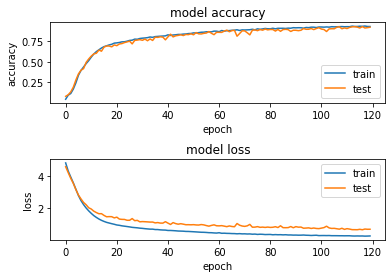

Final Test Accuracy: 0.9278396368026733


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       0.96      1.00      0.98       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.96      0.99      0.98       294
           9       0.99      1.00      1.00       269
          10       0.90      1.00      0.95       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os03g0363600         329              329        True
1  Os01g0173100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.045
1,2,0.073
2,3,0.095
3,4,0.566
4,5,0.707
5,6,0.881
6,7,0.830
7,8,0.890
8,9,0.894
9,10,0.928
